In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *

## Initialize data

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
latex_labels = ['\\mathcal{O}_1', '\\mathcal{O}_2', '\\mathcal{O}_3', '\\mathcal{O}_{1\'}', '\\mathcal{O}_{2\'}']
# colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each ensemble differently

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_24I = [1.784, 0.005]
ainv_32I = [2.382, 0.008]
ainv_list = [ainv_24I, ainv_24I, ainv_32I, ainv_32I, ainv_32I]

# # PDG values
# mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
# fpi_0 = (0.1302, 1.2e-3)
# David's values for testing-- use PDG values after testing
mpi_0   = [ 0.13957018, 0.00000035 ]
fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]    # f_pi^phys = 130.4 MeV

In [3]:
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently
mpi_0_ens, fpi_0_ens = Superboot(n_ens), Superboot(n_ens)
mpi_0_ens.gen_fake_ensemble(mpi_0[0], mpi_0[1])
fpi_0_ens.gen_fake_ensemble(fpi_0[0], fpi_0[1])

# generate lattice ensemble for each size and map between ensemble <--> size
ainv_24I_ens = Superboot(n_ens)
ainv_32I_ens = Superboot(n_ens)
ainv_24I_ens.gen_fake_ensemble(ainv_24I[0], ainv_24I[1])
ainv_32I_ens.gen_fake_ensemble(ainv_32I[0], ainv_32I[1])
ainv_ens = [ainv_24I_ens, ainv_24I_ens, ainv_32I_ens, ainv_32I_ens, ainv_32I_ens]

hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_24I = [(hbarc ** 2) / (ainv_24I[0] ** 2), 2 * (hbarc ** 2) * ainv_24I[1] / (ainv_24I[0] ** 3)]
asq_32I = [(hbarc ** 2) / (ainv_32I[0] ** 2), 2 * (hbarc ** 2) * ainv_32I[1] / (ainv_32I[0] ** 3)]
asq_list = [asq_24I, asq_24I, asq_32I, asq_32I, asq_32I]

asq_24I_ens = ainv_24I_ens ** (-2)
asq_32I_ens = ainv_32I_ens ** (-2)
asq_24I_fms = asq_24I_ens.scale(hbarc ** 2)
asq_32I_fms = asq_32I_ens.scale(hbarc ** 2)
asq_ens = [asq_24I_fms, asq_24I_fms, asq_32I_fms, asq_32I_fms, asq_32I_fms]

In [4]:
print('a for 24I lattices: ' + str(hbarc / ainv_24I[0]) + ' fm')
print('a for 32I lattices: ' + str(hbarc / ainv_32I[0]) + ' fm')

a for 24I lattices: 0.11060874439461883 fm
a for 32I lattices: 0.08284047019311502 fm


### Renormalize bare matrix elements in NPR basis

In [5]:
# get RCs for Z_ij / Z_V^2 and Z_A
rc_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/Z_pert_run.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/Z_pert_run.h5']
fRCs = [h5py.File(path, 'r') for path in rc_paths]
ZijZVsq_24I_NPR = fRCs[0]['MSbar'][()]    # (ens_idx, boot_idx, i, j) in NPR basis
ZijZVsq_32I_NPR = fRCs[1]['MSbar'][()]
[f.close() for f in fRCs]

ZA_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/ZA.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/ZA.h5']
fZAs = [h5py.File(path, 'r') for path in ZA_paths]
ZA_24I = fZAs[0]['ZA'][()]    # (ens_idx, boot_idx)
ZA_32I = fZAs[1]['ZA'][()]
[f.close() for f in fZAs]

[None, None]

In [6]:
k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], dtype = np.float64) / 4.0
kinv = np.linalg.inv(k)
ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)
# get mean and std for 32I to generate fake data for ml0p008
Z32I_mu_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
Z32I_std_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
Z_32Iml0p008 = np.zeros((n_boot, n_ops, n_ops), dtype = np.float64)
for i in range(n_ops):
    for j in range(n_ops):
        tmp = Superboot(2)
        tmp.boots = ZijZVsq_32I_BSM[:, :, i, j]
        Z32I_mu_BSM[i, j] = tmp.compute_mean()
        Z32I_std_BSM[i, j] = tmp.compute_std()
        Z_32Iml0p008[:, i, j] = gen_fake_ensemble([Z32I_mu_BSM[i, j], Z32I_std_BSM[i, j]], n_samples = n_boot)
ZijZVsq_BSM = np.zeros((n_ens, n_boot, n_ops, n_ops), dtype = np.float64)
ZijZVsq_BSM[0] = ZijZVsq_24I_BSM[1]    # 24I/ml0p01
ZijZVsq_BSM[1] = ZijZVsq_24I_BSM[0]    # 24I/ml0p005
ZijZVsq_BSM[2] = Z_32Iml0p008    # 32I/ml0p008
ZijZVsq_BSM[3] = ZijZVsq_32I_BSM[1]    # 32I/ml0p006
ZijZVsq_BSM[4] = ZijZVsq_32I_BSM[0]    # 32I/ml0p004
ZA = np.zeros((n_ens, n_boot), dtype = np.float64)
ZA[0] = ZA_24I[0]
ZA[1] = ZA_24I[1]
ZA[2] = ZA_32I[0]
ZA[3] = ZA_32I[1]
ZA[4] = ZA_32I[2]

In [7]:
# select the renormalization coeffs to use
Zij_BSM = np.einsum('...,...ij->...ij', ZA ** 2, ZijZVsq_BSM)
# Zij_BSM = ZijZVsq_BSM

# Uncomment here if we want to run bare matrix elements
# Zij_BSM = np.zeros((5, 50, 5, 5), dtype = np.float64)
# for a in range(n_ens):
#     for b in range(n_boot):
#         Zij_BSM[a, b] = np.eye(5)

In [8]:
# get final mean and std for each Zij coefficient. Use for each lattice spacing
# TODO if we get the data for the final lattice spacing, add it into 32I
Zij_BSM_24I = np.array([
    np.mean(Zij_BSM[:2], axis = (0, 1)), 
    np.sqrt(np.std(Zij_BSM[0], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[1], axis = 0, ddof = 1) ** 2)
])
Zij_BSM_32I = np.array([
    np.mean(Zij_BSM[2:4], axis = (0, 1)), 
    np.sqrt(np.std(Zij_BSM[2], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[3], axis = 0, ddof = 1) ** 2)
])
Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [9]:
print('24I renormalization:\n' + str(Zij_BSM_24I[0]))
print('Error:\n' + str(Zij_BSM_24I[1]))
print(export_matrix_latex(Zij_BSM_24I[0], Zij_BSM_24I[1]))

24I renormalization:
[[ 0.61248736  0.          0.         -0.07229296  0.        ]
 [ 0.          0.53667999  0.          0.         -0.02895547]
 [ 0.          0.          0.53354813  0.          0.        ]
 [-0.06237805  0.          0.          0.57721769  0.        ]
 [ 0.          0.01487703  0.          0.          0.67536391]]
Error:
[[0.00072959 0.         0.         0.00022076 0.        ]
 [0.         0.00089293 0.         0.         0.00022316]
 [0.         0.         0.0007474  0.         0.        ]
 [0.00021716 0.         0.         0.00096925 0.        ]
 [0.         0.00018815 0.         0.         0.00078315]]
\begin{pmatrix} 0.61249(73) & 0 & 0 & -0.07229(22) & 0 \\ 0 & 0.53668(89) & 0 & 0 & -0.02896(22) \\ 0 & 0 & 0.53355(75) & 0 & 0 \\ -0.06238(22) & 0 & 0 & 0.57722(97) & 0 \\ 0 & 0.01488(19) & 0 & 0 & 0.67536(78) \end{pmatrix}


In [10]:
print('32I renormalization:\n' + str(Zij_BSM_32I[0]))
print('Error:\n' + str(Zij_BSM_32I[1]))
print(export_matrix_latex(Zij_BSM_32I[0], Zij_BSM_32I[1]))

32I renormalization:
[[ 0.66569708  0.          0.         -0.08584513  0.        ]
 [ 0.          0.53781179  0.          0.         -0.01411132]
 [ 0.          0.          0.5928421   0.          0.        ]
 [-0.05351079  0.          0.          0.55914592  0.        ]
 [ 0.          0.04306327  0.          0.          0.76546209]]
Error:
[[0.00176168 0.         0.         0.00023966 0.        ]
 [0.         0.00173168 0.         0.         0.00031061]
 [0.         0.         0.0017948  0.         0.        ]
 [0.00027624 0.         0.         0.00187575 0.        ]
 [0.         0.00042652 0.         0.         0.00206362]]
\begin{pmatrix} 0.6657(18) & 0 & 0 & -0.08585(24) & 0 \\ 0 & 0.5378(17) & 0 & 0 & -0.01411(31) \\ 0 & 0 & 0.5928(18) & 0 & 0 \\ -0.05351(28) & 0 & 0 & 0.5591(19) & 0 \\ 0 & 0.04306(43) & 0 & 0 & 0.7655(21) \end{pmatrix}


#### New error propagation, mult by mean and spread boots

In [11]:
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])

a4_mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare a^4 (mat elems)
mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
Lam_chi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    mat_elems_bare_b = np.zeros((n_ops, n_boot), dtype = np.float64)
    print(config)
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        # mult_factor = 1 / 8    # based off the actual contractions, this should be the correct one to use
        # a4_mat_elems_raw[:, i] *= mult_factor
        mat_elems_bare_b[i] = (ainv_list[ens_idx][0] ** 4) * a4_mat_elems_raw[:, i]
        new_std = np.sqrt((4 * (ainv_list[ens_idx][0] ** 3) * np.mean(a4_mat_elems_raw[:, i]) * ainv_list[ens_idx][1]) ** 2 + ((ainv_list[ens_idx][0] ** 4) * np.std(a4_mat_elems_raw[:, i], ddof = 1)) ** 2)
        mat_elems_bare_b[i] = spread_boots(mat_elems_bare_b[i], new_std)
        a4_mat_elems_ens[ens_idx][i] = Superboot(n_ens)
        a4_mat_elems_ens[ens_idx][i].populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        mat_elems_bare[ens_idx][i].populate_ensemble(mat_elems_bare_b[i], ens_idx)
        # a4_mat_elems_ens[ens_idx][i] = a4_mat_elems_ens[ens_idx][i].scale(1 / mult_factor)    # print out original a4matelems
        print(labels[i] + ' bare: ' + str(np.mean(a4_mat_elems_raw[:, i])))
        # mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    # renormalize matrix elements
    mat_elems_renorm_b = np.einsum('ij,jb->ib', Zij_all[ens_idx, 0], mat_elems_bare_b)
    new_err = np.sqrt(np.einsum('ij,j->i', Zij_all[ens_idx, 1] ** 2, np.mean(mat_elems_bare_b, axis = 1) ** 2) + \
                      np.einsum('ij,j->i', Zij_all[ens_idx, 0] ** 2, np.std(mat_elems_bare_b, axis = 1, ddof = 1) ** 2))
    for i in range(n_ops):
        mat_elems_renorm_b[i] = spread_boots(mat_elems_renorm_b[i], new_err[i])
        mat_elems_ens[ens_idx][i].populate_ensemble(mat_elems_renorm_b[i], ens_idx)
    # read in two point data
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    
#     # read in David's numbers
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)
#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     Lam_chi_ens[ens_idx] = (fpi_ens[ens_idx] ** 2).scale(8 * (np.pi ** 2))
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))
    
    # this reads in my ampi, afpi from the two point analysis
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi'][()]
    afpi_boot = twopt_data['afpi'][()]
    twopt_data.close()
    # print(np.std(ampi_boot, ddof = 1), ampi_david[ens_idx][1])
    # print(np.std(afpi_boot, ddof = 1), afpi_david[ens_idx][1])
    ampi_spread = spread_boots(ampi_boot, ampi_david[ens_idx][1])    # use David's error
    afpi_spread = spread_boots(afpi_boot, afpi_david[ens_idx][1])
    ampi_shift = shift_boots(ampi_spread, ampi_david[ens_idx][0])
    afpi_shift = shift_boots(afpi_spread, afpi_david[ens_idx][0])
    
    # confirm the shifted and spread boots have the right mean and std
    # print(np.mean(ampi_shift), ampi_david[ens_idx][0])
    # print(np.mean(afpi_shift), afpi_david[ens_idx][0])
    # print(np.std(ampi_shift, ddof = 1), ampi_david[ens_idx][1])
    # print(np.std(afpi_shift, ddof = 1), afpi_david[ens_idx][1])
    
    ampi_ens.populate_ensemble(ampi_shift, ens_idx)
    afpi_ens.populate_ensemble(afpi_shift, ens_idx)
    # ampi_ens.populate_ensemble(ampi_boot, ens_idx)
    # afpi_ens.populate_ensemble(afpi_boot, ens_idx)
    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    Lam_chi_ens[ens_idx] = (fpi_ens[ens_idx] ** 2).scale(8 * (np.pi ** 2))
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

24I/ml_0p01
O1 bare: -0.0057903857361194435
O2 bare: -0.009978939713065085
O3 bare: 0.00034446162769365476
O1p bare: -0.017891598103692494
O2p bare: 0.0024339942580112604
24I/ml_0p005
O1 bare: -0.004869412011089812
O2 bare: -0.008288928547495246
O3 bare: 0.0001740100504164705
O1p bare: -0.01526270064820235
O2p bare: 0.0020304866015416778
32I/ml0p008
O1 bare: -0.0018398760296705601
O2 bare: -0.0028921336578771016
O3 bare: 8.364480503872852e-05
O1p bare: -0.0057218333023842625
O2p bare: 0.0007185185467522815
32I/ml0p006
O1 bare: -0.0016259216071371468
O2 bare: -0.0025531061583252707
O3 bare: 5.6435017560011677e-05
O1p bare: -0.005089393095406077
O2p bare: 0.0006366036067114937
32I/ml0p004
O1 bare: -0.001460400886720847
O2 bare: -0.0022861421882526224
O3 bare: 3.443371842032638e-05
O1p bare: -0.004605228763444435
O2p bare: 0.0005705271501454009


In [12]:
for i in range(n_ens):
    print('Ensemble: ' + ensembles[i])
    print('Lambda_chi, eps_sq = ' + export_float_latex(Lam_chi_ens[i].compute_mean(), Lam_chi_ens[i].compute_std(), \
            sf = 1) + ' & ' + export_float_latex(eps_sq_ens[i].compute_mean(), eps_sq_ens[i].compute_std(), sf = 1))
    print('Lambda_chi, eps_sq_phys = '+export_float_latex(Lam_chi_ens[i].compute_mean(),Lam_chi_ens[i].compute_std(),\
            sf = 1) + ' & '+export_float_latex(eps_sq_phys_ens[i].compute_mean(),eps_sq_ens[i].compute_std(),sf = 1))

Ensemble: 24I/ml_0p01
Lambda_chi, eps_sq = 2.12(1) & 0.0878(6)
Lambda_chi, eps_sq_phys = 2.12(1) & 0.1384(6)
Ensemble: 24I/ml_0p005
Lambda_chi, eps_sq = 1.81(1) & 0.0642(5)
Lambda_chi, eps_sq_phys = 1.81(1) & 0.0868(5)
Ensemble: 32I/ml0p008
Lambda_chi, eps_sq = 2.07(2) & 0.0817(9)
Lambda_chi, eps_sq_phys = 2.07(2) & 0.1261(9)
Ensemble: 32I/ml0p006
Lambda_chi, eps_sq = 1.88(1) & 0.0686(6)
Lambda_chi, eps_sq_phys = 1.88(1) & 0.0961(6)
Ensemble: 32I/ml0p004
Lambda_chi, eps_sq = 1.72(2) & 0.0528(6)
Lambda_chi, eps_sq_phys = 1.72(2) & 0.0676(6)


#### My old code (propagates error by multiplying bootstraps)

In [13]:
# # Generate fake ensembles. 
# mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params.h5'
#     f = h5py.File(path, 'r')
#     a4_mat_elems_raw = f['fits'][()]
#     for i in range(n_ops):
#         # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_raw[:, i] *= mult_factor
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
#         mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#     f.close()
#     # renormalize matrix elements
#     a4_mat_elems_renorm = np.einsum('bij,bj->bi', Zij_BSM[ens_idx], a4_mat_elems_raw)
#     for i in range(n_ops):
#         a4_mat_elems_r_ens = Superboot(n_ens)
#         a4_mat_elems_r_ens.populate_ensemble(a4_mat_elems_renorm[:, i], ens_idx)
#         mat_elems_ens[ens_idx][i] = a4_mat_elems_r_ens * (ainv_ens[ens_idx] ** 4)
#     # read in two point data
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
#     twopt_data = h5py.File(path2pt, 'r')
#     ampi_boot = twopt_data['ampi']
#     afpi_boot = twopt_data['afpi']
#     ampi_ens.populate_ensemble(ampi_boot, ens_idx)
#     afpi_ens.populate_ensemble(afpi_boot, ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's data

In [14]:
# # David's data
# ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
# afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# # enter this data in format [ens_idx, op_idx] with pairs (mu, sigma)
# a4_matelem_david = np.array([
#     [[-0.04648, 0.00025], [-0.07996, 0.00057], [0.002768, 0.000013], [-0.14345, 0.00080], [0.01951, 0.00014]], 
#     [[-0.03903, 0.00026], [-0.06667, 0.00065], [0.0013953, 0.0000095], [-0.12229, 0.00081], [0.01633, 0.00016]], 
#     [[-0.01476, 0.00011], [-0.02323, 0.00024], [0.0006677, 0.0000043], [-0.04591, 0.00036], [0.005778, 0.000061]], 
#     [[-0.013052, 0.000094], [-0.02059, 0.00020], [0.0004511, 0.0000028], [-0.04087, 0.00030], [0.005132, 0.000050]], 
#     [[-0.011753, 0.000091], [-0.01847, 0.00021], [0.0002745, 0.0000022], [-0.03705, 0.00029], [0.004608, 0.000053]]
# ])

# # Generate fake ensembles. 
# mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     mat_elems_bare_b = np.zeros((n_ops, n_boot), dtype = np.float64)
#     for i in range(n_ops):
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.gen_fake_ensemble_axis(a4_matelem_david[ens_idx, i, 0], a4_matelem_david[ens_idx, i, 1], ens_idx)
#         a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
#         mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#         mat_elems_bare_b[i] = mat_elems_bare[ens_idx][i].boots[ens_idx]
#     # renormalize matrix elements
#     mat_elems_renorm_b = np.einsum('ij,jb->ib', Zij_all[ens_idx, 0], mat_elems_bare_b)
#     new_err = np.sqrt(np.einsum('ij,j->i', Zij_all[ens_idx, 1] ** 2, np.mean(mat_elems_bare_b, axis = 1) ** 2) + \
#                       np.einsum('ij,j->i', Zij_all[ens_idx, 0] ** 2, np.std(mat_elems_bare_b, axis = 1, ddof = 1) ** 2))
#     for i in range(n_ops):
#         mat_elems_renorm_b[i] = spread_boots(mat_elems_renorm_b[i], new_err[i])
#         mat_elems_ens[ens_idx][i].populate_ensemble(mat_elems_renorm_b[i], ens_idx)
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     # This reads in david's values for ampi, afpi and should be used for testing.
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(16 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(16 * (np.pi**2))
# #     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
# #     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's 2pt function data with my matrix elements

In [15]:
# # Generate fake ensembles. 
# ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
# afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
#     f = h5py.File(path, 'r')
#     a4_mat_elems_raw = f['fits'][()]
#     for i in range(n_ops):
#         # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
#         a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
#         mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#     f.close()
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     # This reads in david's values for ampi, afpi and should be used for testing.
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Propagate error and print data

In [16]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
a4_mat_elems_bare_mu = np.array([[a4_mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
a4_mat_elems_bare_sigma = np.array([[a4_mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_bare_mu = np.array([[mat_elems_bare[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_bare_sigma = np.array([[mat_elems_bare[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_mu = np.array([[mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_sigma = np.array([[mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mpi_mu = np.array([mpi_ens[i].compute_mean() for i in range(n_ens)])
mpi_sigma = np.array([mpi_ens[i].compute_std() for i in range(n_ens)])
fpi_mu = np.array([fpi_ens[i].compute_mean() for i in range(n_ens)])
fpi_sigma = np.array([fpi_ens[i].compute_std() for i in range(n_ens)])
eps_mu = np.array([eps_sq_ens[i].compute_mean() for i in range(n_ens)])
eps_sigma = np.array([eps_sq_ens[i].compute_std() for i in range(n_ens)])
eps_phys_mu = np.array([eps_sq_phys_ens[i].compute_mean() for i in range(n_ens)])
eps_phys_sigma = np.array([eps_sq_phys_ens[i].compute_std() for i in range(n_ens)])
ainv_ens_mu = np.array([ainv_ens[i].compute_mean() for i in range(n_ens)])
ainv_ens_sigma = np.array([ainv_ens[i].compute_std() for i in range(n_ens)])
asq_ens_mu = np.array([asq_ens[i].compute_mean() for i in range(n_ens)])
asq_ens_sigma = np.array([asq_ens[i].compute_std() for i in range(n_ens)])

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print('a^4 ' + labels[op_idx]+' bare: ' + str(a4_mat_elems_bare_mu[ens_idx][op_idx]) + ' \pm ' \
              + str(a4_mat_elems_bare_sigma[ens_idx][op_idx]) + ' (GeV)^4')
        print(labels[op_idx]+' bare: '+str(mat_elem_bare_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_bare_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
        print(labels[op_idx]+' renorm: '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.431043352674778 \pm 0.001413560086757563 GeV
f_pi: 0.16372869802363 \pm 0.0006548326452035073 GeV
epsilon_pi_sq: 0.08778196170053712 \pm 0.0006425050999079086
epsilon_pi_phys_sq (to plot at): 0.13835606956189003 \pm 0.0006154961404030495
a^4 O1 bare: -0.0057903857361194435 \pm 4.703728894056271e-05 (GeV)^4
O1 bare: -0.058652549687577056 \pm 0.0008120146139084246 (GeV)^4
O1 renorm: -0.022822339075578863 \pm 0.0005331356153736351 (GeV)^4
a^4 O2 bare: -0.009978939713065085 \pm 0.00010916435216080567 (GeV)^4
O2 bare: -0.1010796661954565 \pm 0.00158328733365911 (GeV)^4
O2 renorm: -0.054961321614336325 \pm 0.0008545885321387398 (GeV)^4
a^4 O3 bare: 0.0003444616276936547 \pm 2.3950906057547494e-06 (GeV)^4
O3 bare: 0.0034891548947662368 \pm 4.602873452782773e-05 (GeV)^4
O3 renorm: 0.0018616320810126209 \pm 2.469661283280922e-0

In [17]:
# Table 2: dimensionless bare matrix elements
col_labels = ['\\rule{0cm}{0.4cm}Ensemble', '$a m_\\ell$']
for i in range(n_ops):
    col_labels.append('$a^4 \\langle \\pi^+ | ' + latex_labels[i] + ' | \\pi^- \\rangle$')
col_labels = np.array(col_labels)
# row_labels = np.array([['\\rule{0cm}{0.4cm} 24I', '0.01'], ['24I', '0.005'], ['\\rule{0cm}{0.4cm} 32I', '0.008'], ['32I', '0.006'], ['32I', '0.004']])
row_labels = np.array([['\\rule{0cm}{0.4cm}\multirow{2}{*}{24I}', '0.01'], [' ', '0.005'], ['\\rule{0cm}{0.4cm}\multirow{3}{*}{32I}', '0.008'], [' ', '0.006'], [' ', '0.004']])
a4matelems_fmt = Table(a4_mat_elems_bare_mu, is_entry = False, sigma = a4_mat_elems_bare_sigma)
a4_mat_elems_table = export_vert_table_latex(a4matelems_fmt, col_labels, row_labels = row_labels, hline_idxs = [0, 2], \
                                             header = '\\begin{tabular}{ cc | ccccc } \\hline \\hline ')
print('Format string for dimensionless mat elems table')
print(a4_mat_elems_table)

Format string for dimensionless mat elems table
\begin{tabular}{ cc | ccccc } \hline \hline \rule{0cm}{0.4cm}Ensemble & $a m_\ell$ & $a^4 \langle \pi^+ | \mathcal{O}_1 | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_2 | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_3 | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_{1'} | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_{2'} | \pi^- \rangle$ \\  \hline \rule{0cm}{0.4cm}\multirow{2}{*}{24I} & 0.01 & -0.005790(47) & -0.00998(11) & 0.0003445(24) & -0.01789(15) & 0.002434(26) \\   & 0.005 & -0.004869(40) & -0.00829(10) & 0.0001740(16) & -0.01526(13) & 0.002030(26) \\  \hline \rule{0cm}{0.4cm}\multirow{3}{*}{32I} & 0.008 & -0.001840(20) & -0.002892(43) & 0.00008364(78) & -0.005722(64) & 0.000719(11) \\   & 0.006 & -0.001626(18) & -0.002553(32) & 0.00005644(44) & -0.005089(56) & 0.0006366(79) \\   & 0.004 & -0.001460(16) & -0.002286(36) & 0.00003443(33) & -0.004605(52) & 0.0005705(93) \\  \hline \hline \end{tabular} 


In [18]:
# Table 3: dimensionless bare matrix elements (add in ncfgs column)
col_labels = ['\\rule{0cm}{0.4cm}Ensemble', '$a m_\\ell$']
mat_elem_mu_array = np.array([[mat_elem_mu[ens_idx][op_idx] for op_idx in range(n_ops)] for ens_idx in range(n_ens)])
mat_elem_sigma_array = np.array([[mat_elem_sigma[ens_idx][op_idx] for op_idx in range(n_ops)] for ens_idx in range(n_ens)])
for i in range(n_ops):
    col_labels.append('$\\langle \\pi^+ | ' + latex_labels[i] + '^{\\overline{\\mathrm{MS}}} | \\pi^- \\rangle\;(\\mathrm{GeV}^4)$')
col_labels = np.array(col_labels)
# row_labels = np.array([['\\rule{0cm}{0.4cm} 24I', '0.01'], ['24I', '0.005'], ['\\rule{0cm}{0.4cm} 32I', '0.008'], ['32I', '0.006'], ['32I', '0.004']])
row_labels = np.array([['\\rule{0cm}{0.4cm}\multirow{2}{*}{24I}', '0.01'], [' ', '0.005'], ['\\rule{0cm}{0.4cm}\multirow{3}{*}{32I}', '0.008'], [' ', '0.006'], [' ', '0.004']])
matelems_fmt = Table(mat_elem_mu_array, is_entry = False, sigma = mat_elem_sigma_array)
a4_mat_elems_table = export_vert_table_latex(matelems_fmt, col_labels, row_labels = row_labels, hline_idxs = [0, 2], \
                                             header = '\\begin{tabular}{ cc | ccccc } \\hline \\hline ')
print('Format string for renormalized mat elems table')
print(a4_mat_elems_table)

Format string for renormalized mat elems table
\begin{tabular}{ cc | ccccc } \hline \hline \rule{0cm}{0.4cm}Ensemble & $a m_\ell$ & $\langle \pi^+ | \mathcal{O}_1^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_2^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_3^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_{1'}^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_{2'}^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ \\  \hline \rule{0cm}{0.4cm}\multirow{2}{*}{24I} & 0.01 & -0.02282(53) & -0.05496(85) & 0.001862(25) & -0.1010(15) & 0.01515(26) \\   & 0.005 & -0.01903(45) & -0.04566(76) & 0.000940(14) & -0.0862(13) & 0.01264(24) \\  \hline \rule{0cm}{0.4cm}\multirow{3}{*}{32I} & 0.008 & -0.02362(75) & -0.0504(10) & 0.001596(27) & -0.0998(18) & 0.01370(37) \\   & 0.006 & -0.02078(66) & -0.04449(83) & 0.001077(1

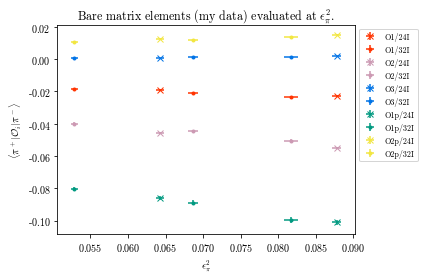

In [19]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
markers = ['v', 'v', '.', '.', '.']
plt.figure()
for i in range(n_ops):
#     plt.errorbar(eps_phys_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
#     plt.errorbar(eps_phys_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
    plt.errorbar(eps_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
    plt.errorbar(eps_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('$\\langle \pi^+ | \mathcal{O}_i | \pi^- \\rangle$')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 8})
# plt.xlim((0.025, 0.045))
# plt.ylim((0.015, 0.029))
# plt.title('Renormalized matrix elements evaluated at $\epsilon_\pi^2|_{f_0}$.')

# plt.vlines(eps_sq_0, -0.08, 0.02, linestyles = 'dashed', label = '$\epsilon^2_{\mathrm{PDG}}$')
# plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], O_phys_mu, yerr = O_phys_sigma, c = 'k', fmt = 'o')

plt.title('Bare matrix elements (my data) evaluated at $\epsilon_\pi^2$.')
plt.tight_layout()
plt.show()

## Perform the fit

In [20]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
def get_fv_fn(op_idx):
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)

In [21]:
# Define functional fit forms for the operators
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

#### Fit to mean

For a given operator $\mathcal O^k$, this should be changed to a correlated fit between $(m_\pi, f_\pi, \mathcal O^k)$ on each ensemble. The covariance matrix will be 15 x 15 ($n_{ens}$ times len($(m_\pi, f_\pi, \mathcal O^k)$)) block-diagonal matrix, where each block is $3\times 3$. 

In [22]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3
4


In [23]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

Results of fits to mean:
α | β | c
O1
[-4.65816021 -1.35205308 -0.52851541]
O2
[11.02056003 -2.62472528 -1.0685444 ]
O3
[6.08359809 0.4538346  0.19148668]
O1p
[ 1.8134607  -5.79266192 -1.19473234]
O2p
[13.22974846  0.71692863 -1.30503171]


#### Fit to full data

In [24]:
alpha = [Superboot(n_ens) for i in range(n_ops)]
beta = [Superboot(n_ens) for i in range(n_ops)]
c = [Superboot(n_ens) for i in range(n_ops)]
# store the matrix elements after subtraction here. phys == actual results subtracted back to the physical point, 
# subtracted == extrapolated results to physical decay constant and lattice spacing at different pion masses. 
# plot eps_sq_subtracted vs mat_elems_subtracted.
mat_elems_phys = [Superboot(n_ens) for j in range(n_ops)]    # extrapolate to the physical pion mass
mat_elems_subtracted = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
chi2_boots = [Superboot(n_ens) for i in range(n_ops)]
chi2_ndof_boots = [Superboot(n_ens) for i in range(n_ops)]
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
band_data = [[Superboot(n_ens) for j in range(n_ops)] for i in range(len(m_range) - 1)]
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            f_boot = np.array([fpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[i], L_cfgs[i], ainv_boot[i]) for i in range(n_ens)])
            O_boot = np.array([mat_elems_ens[i][op_idx].boots[ens_idx, b_idx] for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            alphab, betab, cb = out['x']
            print(alphab, betab, cb)
            alpha[op_idx].boots[ens_idx, b_idx] = alphab
            beta[op_idx].boots[ens_idx, b_idx] = betab
            c[op_idx].boots[ens_idx, b_idx] = cb
            chi2_boots[op_idx].boots[ens_idx, b_idx] = out.fun
            chi2_ndof_boots[op_idx].boots[ens_idx, b_idx] = out.fun / (n_ens - 3.0)   # 5 - 3, for 3 fit params
            # subtract off extrapolation @ phys point to get extrapolated matrix element
            mat_elems_phys[op_idx].boots[ens_idx, b_idx] = O_list[op_idx](alphab, betab, cb, mpi_0_ens.boots[ens_idx, b_idx], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            
            # subtract off artifacts and extrapolate everything but the pion mass away-- these are the plotted points
            for i in range(n_ens):
                mat_elems_subtracted[i][op_idx].boots[ens_idx, b_idx] = O_boot[i] \
                    - O_list[op_idx](alphab, betab, cb, m_boot[i], f_boot[i], asq_boot[i], fv_boot[i]) \
                    + O_list[op_idx](alphab, betab, cb, m_boot[i], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            for m in range(len(m_range) - 1):    # extrapolate to value m for the pion mass
                band_data[m][op_idx].boots[ens_idx, b_idx] = \
                    O_list[op_idx](alphab, betab, cb, m_range[m + 1], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)

Operator O1
Ensemble 0, boot 0
-4.47898500719513 -1.337902933402418 -0.5155752992232703
Ensemble 0, boot 1
-4.8334580253769195 -1.3650425372449273 -0.550529663435431
Ensemble 0, boot 2
-5.134738572473758 -1.3788365787064678 -0.6836133934075923
Ensemble 0, boot 3
-5.386790489393137 -1.4014154064946287 -0.6733145263530923
Ensemble 0, boot 4
-4.311075228883534 -1.3332762897666655 -0.4149269075367094
Ensemble 0, boot 5
-5.310724940972891 -1.3835640811207834 -0.7700872562098814
Ensemble 0, boot 6
-5.176027525255176 -1.3742127937954645 -0.733489592191484
Ensemble 0, boot 7
-4.917328812264103 -1.3706199870373885 -0.5647176142607729
Ensemble 0, boot 8
-4.3907407992949885 -1.3390218622560615 -0.42189312154263736
Ensemble 0, boot 9
-5.895613011486792 -1.4249922564619897 -0.893269939873448
Ensemble 0, boot 10
-5.159176832382959 -1.3895491521259273 -0.5799518199900568
Ensemble 0, boot 11
-4.089907064719276 -1.3161017911490385 -0.4155816512788962
Ensemble 0, boot 12
-4.405528922587319 -1.3360418072

-4.190847499540328 -1.3530765418541189 -0.6027913921600583
Ensemble 2, boot 5
-4.788756438979046 -1.3524119929867227 -0.5089004301992601
Ensemble 2, boot 6
-5.224127508080771 -1.3476788491323028 -0.4335674090450826
Ensemble 2, boot 7
-3.9226339304786197 -1.3403866790637418 -0.6272538976642297
Ensemble 2, boot 8
-7.975736316867079 -1.3658979700374658 -0.015733982132690134
Ensemble 2, boot 9
-3.1939091488414726 -1.3419081479311084 -0.7415006111521066
Ensemble 2, boot 10
-5.439305989461878 -1.3456410781265138 -0.39473641548419497
Ensemble 2, boot 11
-4.809552483373655 -1.3567601947673338 -0.5112138224112912
Ensemble 2, boot 12
-7.1857691744346415 -1.3583331844325883 -0.14134494065437042
Ensemble 2, boot 13
-4.905491565865942 -1.3470001291539704 -0.48384350219139904
Ensemble 2, boot 14
-5.629529558705866 -1.354175804073116 -0.3771718193017563
Ensemble 2, boot 15
-0.7420790087680267 -1.3551448926464247 -1.1452057388009507
Ensemble 2, boot 16
-2.6911951916493053 -1.354732476874167 -0.8382317

-5.12529206521257 -1.3946783586087805 -0.6809708513141318
Ensemble 4, boot 9
-4.2355334279467245 -1.316297485374283 -0.3941928649121044
Ensemble 4, boot 10
-5.184673685431218 -1.4000436949980015 -0.686093254550063
Ensemble 4, boot 11
-5.090898807107642 -1.391376637824963 -0.6857985264209371
Ensemble 4, boot 12
-4.262811942057203 -1.3181743728360036 -0.3529514118646708
Ensemble 4, boot 13
-4.213305173262927 -1.311218339184539 -0.34846585167926913
Ensemble 4, boot 14
-4.160786071884684 -1.308663037468753 -0.3544328178791016
Ensemble 4, boot 15
-4.781475467444402 -1.3628947616596452 -0.5589910149579053
Ensemble 4, boot 16
-5.7600752439220875 -1.4541227457936234 -0.9600941832001021
Ensemble 4, boot 17
-5.361600414087144 -1.415816248847294 -0.744495801180505
Ensemble 4, boot 18
-4.911364096815603 -1.3754515386024586 -0.6973378398658855
Ensemble 4, boot 19
-5.07434884517782 -1.3896099909398896 -0.633964302532505
Ensemble 4, boot 20
-4.438372836805139 -1.3324953278967528 -0.458152029019695
En

12.806628835852724 -2.6681123232795243 -1.3934334584424937
Ensemble 1, boot 14
12.88819246166606 -2.659565257852875 -1.3953175241447622
Ensemble 1, boot 15
12.068186984947884 -2.6464542003064593 -1.2555652241185884
Ensemble 1, boot 16
10.126659964995104 -2.619484841383301 -0.9234027063326858
Ensemble 1, boot 17
9.246333612408327 -2.6072819615864646 -0.7721216592559118
Ensemble 1, boot 18
7.831626451934459 -2.572178948432311 -0.5074334172095005
Ensemble 1, boot 19
10.42758334072026 -2.667322795160885 -1.0288815586735385
Ensemble 1, boot 20
11.182681197536771 -2.664715954672497 -1.1420919743691944
Ensemble 1, boot 21
10.771640652890396 -2.6283918091560645 -1.0357696205262206
Ensemble 1, boot 22
10.130678661434986 -2.5794571304822687 -0.8746590273216486
Ensemble 1, boot 23
9.972686656348671 -2.595531056202803 -0.8705412403244912
Ensemble 1, boot 24
10.410920718968983 -2.5971794821716507 -0.9407119947623146
Ensemble 1, boot 25
14.358892933034456 -2.674361489922753 -1.6415880123942979
Ensem

11.447118598799257 -2.6056876612690942 -1.083027044503101
Ensemble 3, boot 20
11.038383223566102 -2.6117685157871584 -1.0691480207848016
Ensemble 3, boot 21
11.692197596207322 -2.5878167556733582 -1.0909039887470544
Ensemble 3, boot 22
9.335161028364338 -2.6555982389501183 -0.9864301017727212
Ensemble 3, boot 23
12.40179574099628 -2.580793994457819 -1.1159826570860047
Ensemble 3, boot 24
11.89784305568053 -2.6016845615555146 -1.1002763260276287
Ensemble 3, boot 25
9.611633256711261 -2.662528953907543 -1.0073687053197056
Ensemble 3, boot 26
8.93849095583606 -2.6839495191761986 -0.9666285279159426
Ensemble 3, boot 27
11.156149108472182 -2.6059155555440094 -1.0708957314181111
Ensemble 3, boot 28
11.502435058833212 -2.60982989212817 -1.0855857974025813
Ensemble 3, boot 29
13.396729433463548 -2.5366021508174317 -1.1386414466432906
Ensemble 3, boot 30
9.40952052672794 -2.6866945950521814 -1.000579247465472
Ensemble 3, boot 31
11.634504228052132 -2.5961185319736386 -1.089253582916429
Ensemble

8.070505757337486 0.4360479683593325 0.8345552624574524
Ensemble 0, boot 26
3.874923975576623 0.47491805300938406 -0.6416536899605162
Ensemble 0, boot 27
5.8047574661293755 0.4564472606201735 0.0839313227476055
Ensemble 0, boot 28
6.89795542572174 0.4461991212977795 0.4278776598922371
Ensemble 0, boot 29
6.794098039093664 0.4464847075135706 0.3058680178595985
Ensemble 0, boot 30
6.213864294420955 0.45286474704975105 0.2773213426464558
Ensemble 0, boot 31
6.860498107916099 0.44599486348799544 0.3153262727426661
Ensemble 0, boot 32
5.3656409648844505 0.46042152135924297 -0.0878224705700296
Ensemble 0, boot 33
3.2758331934037077 0.4801359214019598 -0.8153605459501918
Ensemble 0, boot 34
5.055584587094436 0.46233211185145856 -0.31833396348123383
Ensemble 0, boot 35
5.155505337750672 0.46245388728782877 -0.1607108374816944
Ensemble 0, boot 36
5.934719659365101 0.45501830412178884 0.09488858574954909
Ensemble 0, boot 37
5.366671646522756 0.46090914575162073 -0.004602806181952784
Ensemble 0, 

8.194124231652173 0.45741331204241786 -0.2902617057468818
Ensemble 2, boot 33
5.948805457518477 0.4559879772840195 0.18239469115807047
Ensemble 2, boot 34
6.036829523368363 0.45619997610528357 0.1498969290009534
Ensemble 2, boot 35
6.611219838610005 0.44737962609306053 0.2225393826946901
Ensemble 2, boot 36
7.175613911587733 0.44691764478424945 0.1107797599376558
Ensemble 2, boot 37
7.463601746690183 0.4490011718625677 0.031509795279686274
Ensemble 2, boot 38
4.986767157931317 0.44654164982380473 0.5465425448089435
Ensemble 2, boot 39
7.811000365721712 0.45411725265502384 -0.1354867680828826
Ensemble 2, boot 40
7.801650778561681 0.4589262903015343 -0.2339771138832486
Ensemble 2, boot 41
6.54823328706902 0.4571533967002431 0.04110292636224021
Ensemble 2, boot 42
5.720503464192183 0.4578384114787193 0.18051757082910927
Ensemble 2, boot 43
4.7492680968014085 0.4555508932920448 0.41222983401688756
Ensemble 2, boot 44
2.1040936913861548 0.45122870139813887 1.008417519224415
Ensemble 2, boot

4.901812205802391 0.47460168350274284 -0.5273101189080294
Ensemble 4, boot 40
5.812528988669671 0.461214367347389 -0.20162966849337632
Ensemble 4, boot 41
4.671786003548428 0.4806031949534291 -0.7157552873248798
Ensemble 4, boot 42
5.610508010189828 0.46087381828127216 0.02248283066311094
Ensemble 4, boot 43
6.720244986696013 0.44020900110158584 0.9108655994210444
Ensemble 4, boot 44
4.9475114066183306 0.47357731887100324 -0.43623886979877885
Ensemble 4, boot 45
6.284343608434281 0.45026527073733147 0.32448709965027356
Ensemble 4, boot 46
6.881534674329493 0.44014167918149766 0.6876299697174999
Ensemble 4, boot 47
5.900104033021516 0.45844241011157305 -0.06152426346465538
Ensemble 4, boot 48
7.1056297448358166 0.4364394982706055 0.8273810530740267
Ensemble 4, boot 49
7.10376020832725 0.4383274821343287 0.6741884478139892
Operator O1p
Ensemble 0, boot 0
1.7620343144793436 -5.777400120489397 -1.2343543855495256
Ensemble 0, boot 1
1.7098610260353455 -5.826770387631603 -1.1891959715763314


5.691371878683337 -5.9261116215276575 -1.8299953557120205
Ensemble 1, boot 46
3.242049832551106 -5.876605182253038 -1.443226572163774
Ensemble 1, boot 47
4.068322169475788 -5.866178576275194 -1.5645899458991213
Ensemble 1, boot 48
0.7719136555443953 -5.742272810059341 -1.0156343492846902
Ensemble 1, boot 49
2.843416795949951 -5.8064303708652005 -1.3564385710118438
Ensemble 2, boot 0
2.494276668059149 -5.814813515418434 -1.3152268571467238
Ensemble 2, boot 1
0.03582070076445114 -5.729535144528403 -0.8709658630555697
Ensemble 2, boot 2
0.5572061534313738 -5.7413511960001555 -0.9653935472368874
Ensemble 2, boot 3
1.2317580457266535 -5.829078758799301 -1.1141576969390867
Ensemble 2, boot 4
1.9790084375290666 -5.799049322809934 -1.2247009217149478
Ensemble 2, boot 5
1.994856707779732 -5.795144755116765 -1.2257462180992003
Ensemble 2, boot 6
1.4334836958884543 -5.770506022277563 -1.1225856140907333
Ensemble 2, boot 7
2.0807384198628274 -5.744301835185996 -1.2182511099321873
Ensemble 2, boot 

1.728150263135485 -5.815821512105491 -1.1628662057763253
Ensemble 4, boot 2
1.6617154847371862 -5.838237978692175 -1.2134077218508674
Ensemble 4, boot 3
1.234005598787245 -5.979849600470774 -1.3199353331512067
Ensemble 4, boot 4
2.1833330603116368 -5.673782231571836 -1.0744407039000758
Ensemble 4, boot 5
1.5197698174943959 -5.884971026192552 -1.2104270813553628
Ensemble 4, boot 6
1.4908304977261517 -5.895168536761616 -1.2579383508333837
Ensemble 4, boot 7
1.7758857158435353 -5.797674253677115 -1.1532676914932858
Ensemble 4, boot 8
1.6023118381807346 -5.858676728959303 -1.2348898038198703
Ensemble 4, boot 9
2.081166076494452 -5.711760949054902 -1.1360412097938442
Ensemble 4, boot 10
1.3275227166278778 -5.948937586532669 -1.303295763221325
Ensemble 4, boot 11
1.4275311378881068 -5.9174391902769194 -1.308487358344496
Ensemble 4, boot 12
1.998729865836764 -5.7350593412325805 -1.1106026086894645
Ensemble 4, boot 13
2.35717937578217 -5.616272893567333 -1.0172055000559561
Ensemble 4, boot 14


13.556610208265555 0.7168314600400483 -1.3577927608769522
Ensemble 1, boot 8
11.895254501707138 0.7140819618107582 -1.0676728049911686
Ensemble 1, boot 9
12.84851908868569 0.7195023645963096 -1.2563098779290953
Ensemble 1, boot 10
12.560114096423868 0.7306118547502707 -1.2627621739873043
Ensemble 1, boot 11
13.32108391061788 0.7104422634424893 -1.2867145445634303
Ensemble 1, boot 12
11.006259545083106 0.7008321346112956 -0.8490231277185482
Ensemble 1, boot 13
15.24103275070233 0.7333680102597971 -1.7193717935428774
Ensemble 1, boot 14
15.350430202946248 0.731197841481951 -1.7263185180440985
Ensemble 1, boot 15
14.285409673712628 0.7246071669329629 -1.5187291944940722
Ensemble 1, boot 16
12.14432220537378 0.7130111098361177 -1.1032898024307116
Ensemble 1, boot 17
11.371768866834222 0.7091517238751444 -0.9543140931914634
Ensemble 1, boot 18
9.407504285717984 0.693899490251865 -0.5429206886713066
Ensemble 1, boot 19
12.66741690495739 0.7286083939363003 -1.2707132152149034
Ensemble 1, boot

16.892537381745935 0.6855403261327139 -1.4290700314716624
Ensemble 3, boot 15
12.15862857703563 0.7253613208119577 -1.266537365398767
Ensemble 3, boot 16
14.1106359168238 0.7094993462136024 -1.3391237857716725
Ensemble 3, boot 17
11.859424153151414 0.7294910071953544 -1.253006390194387
Ensemble 3, boot 18
11.60677891449828 0.728445801122583 -1.2320791969917777
Ensemble 3, boot 19
14.050969454595563 0.7086190273800944 -1.3359441061938953
Ensemble 3, boot 20
13.084183528236984 0.7148070411218811 -1.2991862817536537
Ensemble 3, boot 21
13.84991290542008 0.7075952697990416 -1.3280972425695077
Ensemble 3, boot 22
11.21434731479172 0.727786259156887 -1.205204993349873
Ensemble 3, boot 23
15.064884100918713 0.7016956375579084 -1.3745251041555906
Ensemble 3, boot 24
14.612943838946943 0.7067667098820631 -1.3595484472630728
Ensemble 3, boot 25
11.715125684292671 0.7277958824886707 -1.23615968239836
Ensemble 3, boot 26
10.911719183582395 0.7346791683901459 -1.1897233293002016
Ensemble 3, boot 27

#### Print mean and std for bootstrapped fit parameters

In [25]:
# chi2_boots[0].compute_mean() / 2

In [26]:
alpha_mu = [alpha[i].compute_mean() for i in range(n_ops)]
alpha_sigma = [alpha[i].compute_std() for i in range(n_ops)]
beta_mu = [beta[i].compute_mean() for i in range(n_ops)]
beta_sigma = [beta[i].compute_std() for i in range(n_ops)]
c_mu = [c[i].compute_mean() for i in range(n_ops)]
c_sigma = [c[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

Fit parameters for operator O1
alpha = -4.64907684500752 \pm 3.748641757450242
beta = -1.3517907177200112 \pm 0.08568362067547998
c = -0.5215082663696127 \pm 0.6582740336679312
Fit parameters for operator O2
alpha = 11.036954785562848 \pm 3.4944107628470484
beta = -2.624106085730583 \pm 0.14647573352388266
c = -1.0623672890320386 \pm 0.5551986729727725
Fit parameters for operator O3
alpha = 6.092765163303675 \pm 3.3200461259441667
beta = 0.4538456211392217 \pm 0.01899914936509284
c = 0.19680034148420616 \pm 0.8005462771911769
Fit parameters for operator O1p
alpha = 1.8216218161365385 \pm 2.946510906081536
beta = -5.791568133107782 \pm 0.2821854265047173
c = -1.190247494770137 \pm 0.48680312271606063
Fit parameters for operator O2p
alpha = 13.254160924559612 \pm 4.0432555335290905
beta = 0.7167696411664642 \pm 0.045467100114861936
c = -1.2983065798111424 \pm 0.6189400270709248


#### Get error on data and print subtracted matrix elements

In [27]:
print('Values of chirally extrapolated operators at physical point.')
O_phys_mu = [mat_elems_phys[i].compute_mean() for i in range(n_ops)]
O_phys_sigma = [mat_elems_phys[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('<pi|' + labels[op_idx] + '|pi> = ' + str(O_phys_mu[op_idx]) + ' \pm ' + str(O_phys_sigma[op_idx]))

Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.014147491743509096 \pm 0.0007955775421815513
<pi|O2|pi> = -0.027228694020261252 \pm 0.0013449335160089907
<pi|O3|pi> = 8.815038054167035e-05 \pm 2.9431574262222733e-06
<pi|O1p|pi> = -0.05997372504517591 \pm 0.0025757880060083213
<pi|O2p|pi> = 0.007409361771342424 \pm 0.0004215984535516067


#### Plot values of the chiral extrapolation at different values of $m_{\pi}$

In [28]:
callat_colors = ['limegreen', 'deepskyblue', 'r', 'g', 'midnightblue']    # use for comparison purposes
# colors = ['r', 'g', 'b', 'c', 'y']

In [29]:
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
# epsilon_sq_range = m_range ** 2 / (16 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
# eps_sq_0 = mpi_0[0] ** 2 / (16 * (np.pi ** 2) * (fpi_0[0] ** 2))
eps_sq_subtracted = [Superboot(n_ens) for i in range(n_ens)]
for i in range(n_ens):
    for ens_idx in range(n_ens):
        for b_idx in range(n_boot):
#             eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (16 * (np.pi**2) \
#                                                             * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
            eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (8 * (np.pi**2) \
                                                            * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
eps_sq_sub_mu = [eps_sq_subtracted[i].compute_mean() for i in range(n_ens)]    # may want to make .avg instead
eps_sq_sub_sigma = [eps_sq_subtracted[i].compute_std() for i in range(n_ens)]
# get data points
mat_elems_sub_mu = [[mat_elems_subtracted[i][j].compute_mean() for i in range(n_ens)] for j in range(n_ops)]
mat_elems_sub_sigma = [[mat_elems_subtracted[i][j].compute_std() for i in range(n_ens)] for j in range(n_ops)]
# get band
# band_data_mu = [[band_data[i][j].compute_mean() for j in range(n_ops)] for i in range(len(m_range) - 1)]
# band_data_sigma = [[band_data[i][j].compute_std() for j in range(n_ops)] for i in range(len(m_range) - 1)]
band_data_mu = np.array([[band_data[i][j].compute_mean() for i in range(len(m_range) - 1)] for j in range(n_ops)])
band_data_sigma = np.array([[band_data[i][j].compute_std() for i in range(len(m_range) - 1)] for j in range(n_ops)])

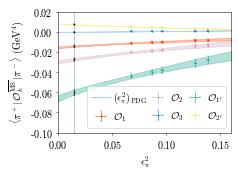

In [60]:
# plot the extrapolation
markers = ['o', 'v', '^', '_', 'x']
style = styles['prd_twocol']
scale = 1        # scale factor to compare to CalLat if we want
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_{1\'} $', '$\mathcal{O}_{2\'} $']
with sns.plotting_context('paper'):
    #plt.figure(figsize = (10, 6))
    asp_ratio = 4/3
    plt.figure(figsize = (style['colwidth'], style['colwidth'] / asp_ratio))
    for j in range(n_ops):
        _, caps, _ = plt.errorbar(eps_sq_sub_mu, scale * np.array(mat_elems_sub_mu[j]), xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                     c = colors[j], fmt = markers[j], label = labels[j], capsize = style['endcaps'], elinewidth = style['ebar_width'], \
                     markersize = style['markersize'])
        plt.fill_between(epsilon_sq_range[1:], scale * np.array(band_data_mu[j]) + band_data_sigma[j], scale * np.array(band_data_mu[j]) - band_data_sigma[j], \
                        color = colors[j], alpha = 0.3)
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
    plt.vlines(eps_sq_0, -0.1, 0.02, linestyles = 'dashed', label = '$(\epsilon^2_\pi)_{\mathrm{PDG}}$', linewidth = style['ebar_width'])
    _, caps, _ = plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], scale * np.array(O_phys_mu), yerr = O_phys_sigma, \
                 c = 'k', fmt = markers[j], capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
    for cap in caps:
        cap.set_markeredgewidth(style['ecap_width'])
    #plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', prop={'size': style['fontsize'] * 0.9}, ncol = 3, handletextpad = 0.2, columnspacing = 1.0)
    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', prop={'size': style['fontsize']}, ncol = 3, handletextpad = 0.2, columnspacing = 0.1)
    plt.xlim((0.0, 0.16))
    #plt.ylim((-0.08, 0.02))
    plt.ylim((-0.1, 0.02))
    plt.xticks(fontsize = style['fontsize'])
    plt.yticks(fontsize = style['fontsize'])
    plt.xlabel('$\epsilon_\pi^2$', fontsize = style['fontsize'])
    plt.ylabel('$\\langle \pi^+| \, \mathcal{O}_k^{\overline{\mathrm{MS}}} \, |\pi^- \\rangle$ (GeV$^4$)', fontsize = style['fontsize'])
    ax = plt.gca()
    ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    for spine in spinedirs:
        ax.spines[spine].set_linewidth(style['axeswidth'])
    plt.tight_layout()
    plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/renorm_chiral_extrap.pdf', bbox_inches='tight')
    plt.show()

In [31]:
# format output table
out_col_labels = np.array(['\\rule{0cm}{0.4cm}Operator', '$\\alpha_k$ ($\\mathrm{fm}^{-2}$)', '$\\beta_k$', '$c_k$', \
            '$\\langle\\pi^+ |\\mathcal{O}_k | \\pi^-\\rangle$ ($\\mathrm{GeV}^4$)', '$\\chi^2 / \\mathrm{dof}$'])
out_hor_labels = np.array(['$' + label + '$' for label in latex_labels])
# out_hor_labels[0] = '\\rule{0cm}{0.4cm}' + out_hor_labels[0]
out_means = np.array([alpha_mu, beta_mu, c_mu, O_phys_mu]).T
out_sigma = np.array([alpha_sigma, beta_sigma, c_sigma, O_phys_sigma]).T
param_table = Table(out_means, is_entry = False, sigma = out_sigma)
chi2_ndof_means = np.array([chi2_ndof.compute_mean() for chi2_ndof in chi2_ndof_boots])
chi2_table = Table(chi2_ndof_means, is_entry = False)
full_table = param_table.insert_cols({4 : chi2_table})
print(export_vert_table_latex(full_table, out_col_labels, out_hor_labels, hline_idxs = [0], \
                              header = '\\begin{tabular}{ c | ccc | c | c } \\hline \\hline '))

\begin{tabular}{ c | ccc | c | c } \hline \hline \rule{0cm}{0.4cm}Operator & $\alpha_k$ ($\mathrm{fm}^{-2}$) & $\beta_k$ & $c_k$ & $\langle\pi^+ |\mathcal{O}_k | \pi^-\rangle$ ($\mathrm{GeV}^4$) & $\chi^2 / \mathrm{dof}$ \\  \hline $\mathcal{O}_1$ & -4.6(3.7) & -1.352(86) & -0.52(66) & -0.01415(80) & 0.33 \\ $\mathcal{O}_2$ & 11.0(3.5) & -2.62(15) & -1.06(56) & -0.0272(13) & 0.59 \\ $\mathcal{O}_3$ & 6.1(3.3) & 0.454(19) & 0.20(80) & 0.0000882(29) & 0.22 \\ $\mathcal{O}_{1'}$ & 1.8(2.9) & -5.79(28) & -1.19(49) & -0.0600(26) & 0.77 \\ $\mathcal{O}_{2'}$ & 13.3(4.0) & 0.717(45) & -1.30(62) & 0.00741(42) & 0.47 \\  \hline \hline \end{tabular} 


## Compare contribution of short-distance to long-distance

The relevant equations that we need for this part are the half-lives of the short-distance vs long-distance decays. The long-distance decay can be ripped out of David's paper:
$$
    (T_{1/2}^{\mathrm{LD}})^{-1} = |m_{\beta\beta}|^2 G_{0\nu} |M^{0\nu}|^2
$$
where $m_{\beta\beta}$ is the neutrino Majorana mass. Likewise, the short-distance decay can be parameterized as:
$$
    (T_{1/2}^{\mathrm{SD}})^{-1} = \sum_k G_{0\nu}^k |M^{0\nu}_k|^2 \eta_k^2
$$
where $\eta_k$ are the new-physics parameters (this is where the Wilson coefficients come in), $G_{0\nu}^k$ are phase space factors, and $M^{0\nu}_k$ are the nuclear matrix elements. Let's simplify this by:
- Assuming that $G_{0\nu}\sim G_{0\nu}^k$ (this might end up being an equality, since the initial and final states are the same)
- Assuming $m_{\beta\beta} \sim \Lambda_\mathrm{LNV}$
Then we need to find the $\eta_k$, and we can compute the relative contributions! But the question: where to find those? These would be related to the Wilson coefficients $c_k$, actually they likely equal $c_k G_F^2 / \Lambda_{LNV}$, since that's the total Wilson coefficient:
\begin{equation}
    \mathcal L_\mathrm{SMEFT}^{0\nu\beta\beta} = \overline{e} e^\mathrm{c} \frac{G_F^2}{\Lambda_\mathrm{LNV}} \sum_k c_k \mathcal O_k
\end{equation}

Should we instead be thinking about the decay amplitude, or the actual half-life? Realistically, the phase space factor is 0, so maybe do $|\mathcal M|^2$ for each one or just $\mathcal M$?

In [61]:
import gvar as gv

In [82]:
# g_nu = −10.78(12)stat(4)ﬁt(50)FV(9)
gnu_mu = -10.78
gnu_sdev = np.sqrt((0.12)**2 + (0.04)**2 + (0.5)**2 + (0.09)**2)
gnu = gv.gvar(gnu_mu, gnu_sdev)

# M^{0ν} = 0.01880(6)(2)(10)(2) GeV^2
M0nu_mean = 0.01880
M0nu_sdev = np.sqrt((6e-5)**2 + (2e-5)**2 + (1e-4)**2 + (2e-5)**2)
M0nu = gv.gvar(M0nu_mean, M0nu_sdev)    # GeV^2

### LEC $g_i^{\pi\pi}$ determination

$$
    O_k\propto \frac{\beta_k \Lambda_{\chi 0}^4}{(4\pi)^2}
$$
for $k\in \{1, 2, 1', 2'\}$, and for $\mathcal O_3$ there is an additional factor of $\epsilon_\pi^2$. The chiral Lagrangian in Cirigliano's paper is:
$$
    \mathcal L = \frac{F_0^2}{2} \left( \frac{5}{3} g_3^{\pi\pi} C_{3} \partial_\mu \pi \partial^\mu\pi + (g_1^{\pi\pi} C_1 + g_1^{\prime \pi \pi} C_1' - g_2^{\pi\pi} C_2 - g_2^{\prime \pi\pi} C_2') \right)
$$
where I've translated the bases, as that paper uses the operator basis $[O3, O2, O2', O1, O1']$. I'm not sure what the $C_i$ coefficients end up being. Here $F_0$ is the pion decay constant in the chiral limit, and $\Lambda_{\chi 0} = 4\pi F_0$. Note they also use the conventions that $F_{phys} = 92.2$ MeV. We see that (if $C_i = 1$, idk how to get them though)
\begin{align}
    \frac{F_0^2}{2} g_1 = \frac{\beta_1 \Lambda_{\chi 0}^4}{(4\pi)^2} = \beta_1 (4\pi)^2 F_0^4 \\
    \implies F_0^2 = \frac{C_1 g_1}{2\beta_1 (4\pi)^2} = \frac{C_1' g_1'}{2\beta_1' (4\pi)^2} = -\frac{C_2 g_2}{2\beta_2 (4\pi)^2} = -\frac{C_2' g_2'}{2\beta_2' (4\pi)^2} = \frac{5C_3 g_3}{6 \epsilon_\pi^2 \beta_3 (4\pi)^2}
\end{align}

In [ ]:
callat_betas = np.array([-1.76, -3.43, 0.924, -6.68, 1.12])
callat_cs = np.array([1.7, 1.1, 2.8, 1.6, -1.5])
cirigliano_gs = np.array([-1.9, 2., 0.36, -8., -0.62])    # GeV^2

In [ ]:
cirigliano_gs / (callat_betas * 2 * (4*np.pi)**2)

We now wish to extract the correlation matrix between the different fit coefficients $\{\alpha^k\}$, $\{\beta^k\}$, and $\{c^k\}$. In the uncorrelated fit, each fit coefficient is computed for each bootstrap on each ensemble to generate an ensemble of fit parameters $\{\alpha^k_{ib}\}$, $\{\beta^k_{ib}\}$, $\{c^k_{ib}\}$, where $k$ is the operator index, $i$ is the ensemble index, and $b$ is the bootstrap index. The ensemble index is uncorrelated, so one can compute the mean and standard deviation of each LEC, for each ensemble. For example, for $\alpha^k$:
\begin{align}
   \overline{\alpha^k_i} = \frac{1}{n_b} \sum_{b} \alpha^k_{ib} && 
   (\delta\alpha^k_i)^2 = \frac{1}{n_b - 1} \sum_b (\alpha_{ib}^k - \overline{\alpha^k_i})^2
\end{align}
These can then be combined into a mean and standard deviation for each LEC, by adding them as uncorrelated variables over their ensemble index:
\begin{align}
    \overline{\alpha^k} = \frac{1}{n_{ens}}\sum_i \overline{\alpha^k_i} && (\delta\alpha^k)^2 = \sum_i (\delta\alpha^k_i)^2
\end{align}

The other statistical information that we would like to obtain from these LECs is their correlation coefficients, where the correlation between two random variables $X$ and $Y$ is defined as the normalized covariance matrix:
$$
    \mathrm{Corr}(X, Y) = \frac{\mathrm{Cov}(X, Y)}{\sigma(X)\sigma(Y)}
$$
The covariance between two LECs (for example $\alpha^k$ and $\beta^\ell$) can be computed ensemble-wise as:
$$
    \mathrm{Cov}_i(\alpha^k, \beta^\ell) = \frac{1}{n_b - 1} \sum_b (\alpha^k_{ib} - \overline{\alpha^k_i}) (\beta^\ell_{ib} - \overline{\beta^\ell_i})
$$
and then summed across ensembles, as the ensemble index is uncorrelated:
$$
    \mathrm{Cov}(\alpha^k, \beta^\ell) = \sum_i \mathrm{Cov}_i(\alpha^k, \beta^\ell).
$$
The correlation can then be assembled:
$$
    \mathrm{Corr}(\alpha^k, \beta^\ell) = \frac{\mathrm{Cov}(\alpha^k, \beta^\ell)}{(\delta\alpha^k)(\delta\beta^\ell)}
$$

In [ ]:
# Get the correlation matrix between the matrix elements, and between the LECs
alpha_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
beta_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
c_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
for k in range(n_ops):
    alpha_boots[k], beta_boots[k], c_boots[k] = alpha[k].boots, beta[k].boots, c[k].boots
LECs = np.concatenate((alpha_boots, beta_boots, c_boots))
n_LECs = LECs.shape[0]
Cov_ens = np.zeros((n_LECs, n_LECs, n_ens))
LECs_ens_mu = np.mean(LECs, axis = 2)
LECs_mu, LECs_sigma = np.zeros((n_LECs), dtype = np.float64), np.zeros((n_LECs), dtype = np.float64)
for k in range(n_LECs):
    LECs_mu[k] = np.mean(LECs[k])
    LECs_sigma[k] = np.sqrt(np.sum(np.std(LECs[k], axis = 1, ddof = 1) ** 2))
# sanity check that LECs_mu and LECs_sigma agrees with previous computation
for k, l in itertools.product(range(n_LECs), repeat = 2):
    for i in range(n_ens):
        Cov_ens[k, l, i] = np.sum((LECs[k, i] - LECs_ens_mu[k, i]) * (LECs[l, i] - LECs_ens_mu[l, i])) / (n_boot - 1)
Cov = np.sum(Cov_ens, axis = 2)
Corr = np.zeros(Cov.shape, dtype = np.float64)
for k, l in itertools.product(range(n_LECs), repeat = 2):
    Corr[k, l] = Cov[k, l] / (LECs_sigma[k] * LECs_sigma[l])

In [ ]:
# Labels for each LEC
end_label = ['1', '2', '3', '1\'', '2\'']
LECs_label = ['$\\alpha^' + end_label[k] + '$' for k in range(n_ops)]
LECs_label.extend(['$\\beta^' + end_label[k] + '$' for k in range(n_ops)])
LECs_label.extend(['$c^' + end_label[k] + '$' for k in range(n_ops)])
for k in range(15):
    print(LECs_label[k], end = ' ')

In [ ]:
# Print correlation matrix in blocks
label_blocks = ['Corr(α, α)', 'Corr(α, β)', 'Corr(α, c)', 'Corr(β, β)', 'Corr(β, c)', 'Corr(c, c)']
index_blocks = [0, 5, 10, 15]    # regions where one LEC stops and another begins
counter = 0
for i, j in itertools.product(range(3), repeat = 2):
    if i > j: 
        continue
    ridx_1, ridx_2 = index_blocks[i], index_blocks[i + 1]
    cidx_1, cidx_2 = index_blocks[j], index_blocks[j + 1]
    subCorr = Corr[ridx_1 : ridx_2, cidx_1 : cidx_2]
    print(label_blocks[counter] + '\n' + export_matrix_latex(subCorr, sf = 3) + '\n')
    counter += 1

## Correlated fit

Here we'll perform a correlated Bayesian fit. On each ensemble, the operator $\mathcal O^{ke}$, the pion mass $m_\pi^e$, and the pion decay constant $f_\pi^e$ are correlated. For now, we'll neglect the correlation between the operator and $(m_\pi, f_\pi)$, but perform a fit taking into account the correlation between $(m_\pi, f_\pi)$. The $\chi^2$ for each operator is:
$$
    \chi^2_k(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}, \vec \alpha, \vec \beta, \vec c) = \chi^2_{obj, k}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}, \alpha^{ke}, \beta^{ke}, c^{ke}) + \chi^2_{prior}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)})
$$
Here $\vec m_{prior}^{(k)} = (m_{prior}^{ek})$ is a vector of parameters for each ensemble (same with $\vec f_{prior}^{(k)}$), and $\vec \alpha = (\alpha^k)$ is a vector of parameters for each operator (same with $\vec\beta$ and $\vec c$). The pion mass and decay constant are allowed to float for each operator to include their correlation with $O$, although the final result we use for the pion mass and decay constant will remain the central values that we have already computed. 

The first term is written in terms of,
$$
    \Delta O^{k} = \begin{pmatrix} 
        \overline{O}^{k1} - \mathcal{F}_k(m_{prior}^{1k}, f_{prior}^{1k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k2} - \mathcal{F}_k(m_{prior}^{2k}, f_{prior}^{2k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k3} - \mathcal{F}_k(m_{prior}^{3k}, f_{prior}^{3k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k4} - \mathcal{F}_k(m_{prior}^{4k}, f_{prior}^{4k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k5} - \mathcal{F}_k(m_{prior}^{5k}, f_{prior}^{5k}, \alpha^k, \beta^k, c^k)
    \end{pmatrix}
$$
where $\overline{O}^{ke}$ is the central value for operator $O^k$ on ensemble $e$, and $\mathcal F_k$ is the functional form for the operator. The objective $\chi^2$ function $\chi^2_{obj, k}$ is defined as,
$$
    \chi^2_{obj, k} = \left(\Delta O^{k}\right)^T \Sigma_k^{-1} \Delta O^k,
$$
where $\Sigma_k$ is the covariance matrix between the operators on each different ensemble,
$$
    \Sigma_k = \mathrm{diag}\left( (\delta O^{k1})^2, (\delta O^{k2})^2, (\delta O^{k3})^2, (\delta O^{k4})^2, (\delta O^{k5})^2 \right),
$$
where $(\delta\mathcal O^{ke})^2$ is the variance of operator $k$ on ensemble $e$, computed over each bootstrap.

The prior $\chi^2$ tells us about the correlation between $m_\pi$ and $f_\pi$. Here the deviation vector is:
$$
\vec y^{(k)} = \begin{pmatrix}
    \overline{m}_\pi^{1} - m_{prior}^{1k} \\ 
    \overline{f}_\pi^{1} - f_{prior}^{1k} \\
    \overline{m}_\pi^2 - m_{prior}^{2k} \\
    ... \\
    \overline{f}_\pi^5 - m_{prior}^{5k}
\end{pmatrix}
$$
where the $\overline{\cdot}$ again denotes the central value over bootstraps. This vector is 10 dimensional, and we can combine it into a $\chi^2$ by considering the covariance:
$$
    \Sigma_{prior} = \mathrm{diag} \left( \mathrm{Cov}_1, \mathrm{Cov}_2, \mathrm{Cov}_3, \mathrm{Cov}_4, \mathrm{Cov}_5 \right)
$$
where $\mathrm{Cov}_e$ is the $2\times 2$ covariance matrix computed between $m_\pi$ and $f_\pi$ on ensemble $e$,
$$
    \mathrm{Cov}_e = \begin{pmatrix}
        (\delta m_\pi^e)^2 && \frac{1}{n_b - 1}\sum_b (m_\pi^{eb} - \overline{m_\pi^e}) (f_\pi^{eb} - \overline{f_\pi^e}) \\
        \frac{1}{n_b - 1}\sum_b (m_\pi^{eb} - \overline{m_\pi^e}) (f_\pi^{eb} - \overline{f_\pi^e}) && (\delta f_\pi^e)^2)
    \end{pmatrix}.
$$
These are combined into a correlated $\chi^2$ for the prior:
$$
    \chi^2_{prior}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}) = \vec{y}^{(k)T} \Sigma_{prior}^{-1} \vec y^{(k)}
$$

#### Resave the data in an easier format to use, it's an absolute mess right now

In [ ]:
# get matrix elements
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
bare_mat_elems = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
renorm_mat_elems = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
for k in range(n_ops):
    for i in range(n_ens):
        bare_mat_elems[k, i] = mat_elems_bare[i][k].boots[i]
        renorm_mat_elems[k, i] = mat_elems_ens[i][k].boots[i]

In [ ]:
# get two point functions
mpi_boots_full = np.zeros((n_ens, n_boot), dtype = np.float64)
fpi_boots_full = np.zeros((n_ens, n_boot), dtype = np.float64)
for ens_idx, config in enumerate(ensembles):
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/'+config+'/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi'][()]
    afpi_boot = twopt_data['afpi'][()]
    twopt_data.close()
    ampi_boot_shift = shift_boots(spread_boots(ampi_boot, ampi_david[ens_idx][1]), ampi_david[ens_idx][0])
    afpi_boot_shift = shift_boots(spread_boots(afpi_boot, afpi_david[ens_idx][1]), afpi_david[ens_idx][0])
    ampi_bar, δampi = np.mean(ampi_boot_shift), np.std(ampi_boot_shift, ddof = 1)
    afpi_bar, δafpi = np.mean(afpi_boot_shift), np.std(afpi_boot_shift, ddof = 1)
    new_mpi_err = np.sqrt((δampi ** 2)*(ainv_list[ens_idx][0] ** 2) + (ampi_bar ** 2)*(ainv_list[ens_idx][1] ** 2))
    new_fpi_err = np.sqrt((δafpi ** 2)*(ainv_list[ens_idx][0] ** 2) + (afpi_bar ** 2)*(ainv_list[ens_idx][1] ** 2))
    ampi_boot_shift = ainv_list[ens_idx][0] * ampi_boot_shift
    afpi_boot_shift = ainv_list[ens_idx][0] * afpi_boot_shift
    mpi_spread = spread_boots(ampi_boot_shift, new_mpi_err)
    fpi_spread = spread_boots(afpi_boot_shift, new_fpi_err)
    mpi_boots_full[ens_idx] = mpi_spread
    fpi_boots_full[ens_idx] = fpi_spread

In [ ]:
# write_out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/chi_extrap_data.h5'
# fw = h5py.File(write_out_file, 'w')
# fw['bare_mat_elems'] = bare_mat_elems
# fw['renorm_mat_elems'] = renorm_mat_elems
# fw['mpi'] = mpi_boots_full
# fw['fpi'] = fpi_boots_full
# fw['ainv'] = np.array(ainv_list)
# fw.close()

In [ ]:
# renorm_mat_elems, mpi_boots_full, fpi_boots_full
O_cv = np.mean(renorm_mat_elems, axis = 2)
Sigma_obj_diag = np.std(renorm_mat_elems, ddof = 1, axis = 2) ** 2
Sigma_obj = np.array([np.diag(Sigma_obj_diag[k]) for k in range(n_ops)])
Sigma_obj_inv = np.array([np.linalg.inv(Sigma_obj[k]) for k in range(n_ops)])

In [ ]:
mpi_cv = np.mean(mpi_boots_full, axis = 1)
fpi_cv = np.mean(fpi_boots_full, axis = 1)
Sigma_prior_blocks = np.array([get_covariance(np.array([mpi_boots_full[e], fpi_boots_full[e]]).T) \
                               for e in range(n_ens)])
Sigma_prior = np.zeros((2 * n_ens, 2 * n_ens), dtype = np.float64)
for e in range(n_ens):
    Sigma_prior[2*e : 2*(e + 1), 2*e : 2*(e + 1)] = Sigma_prior_blocks[e]
Sigma_prior_inv = np.linalg.inv(Sigma_prior)

In [ ]:
# def chi2_obj(LECs, mprior, fprior, a_sq, O_val, Sigma_inv):
#     # LECs = 15 dim vector [alpha^1, ..., alpha^5, beta^k, c^k]
#     # mprior, fprior = 5 dim vector for each ensemble
#     val = 0.
#     alphas, betas, cs = LECs[:5], LECs[5:10], LECs[10:15]
#     for k in range(n_ops):
#         fv_fn = get_fv_fn(k)
#         fv = np.array([fv_fn(mprior[e], L_cfgs[e], ainv_list[e][0]) for e in range(n_ens)])
#         Ok_val = O_val[k]
#         DelOk = np.array([Ok_val[e] - O_list[k](alphas[k], betas[k], cs[k], mprior[e], fprior[e], a_sq[e][0], fv[e]) \
#                               for e in range(n_ens)], dtype = np.float64)
#         val += DelOk.T @ Sigma_inv[k] @ DelOk
#     return val
# def chi2_prior(mprior, fprior, mvals, fvals, Sigma_inv):
#     """
#     mprior: mpi_{prior}^e, should be a n_ens dim vector which is minimized
#     fprior: fpi_{prior}^e, should be a n_ens dim vector which is minimized
#     mvals: central values for m_pi^e from the bootstrap, should be a n_ens dim vector
#     fvals: central values for f_pi^e from the bootstrap, should be a n_ens dim vector
#     Sigma_inv: Inverse covariance matrix between (mpi, fpi) on each ensemble. Should be (2n_ens) x (2n_ens), and 
#         2x2 block diagonal.
#     """
#     delM = mprior - mvals
#     delF = fprior - fvals
#     y = np.zeros((10), dtype = np.float64)
#     y[0::2] = delM
#     y[1::2] = delF
#     return y.T @ Sigma_inv @ y
# def corr_chi2(x, a_sq, O_val, mvals, fvals, Sigma_obj_inv, Sigma_prior_inv):
#     """
#     x = [alpha1, ..., alpha_5, beta_1, ..., beta_5, c1, ..., c5, m1, ..., m5, f1, ..., f5]. Note that for the 
#     LECs, the index is for each operator, but for the mpi, fpi the index is for each ensemble
#     """
#     LECs = x[:15]
#     mprior, fprior = x[15:20], x[20:25]
#     return chi2_obj(LECs, mprior, fprior, a_sq, O_val, Sigma_obj_inv) \
#                                 + chi2_prior(mprior, fprior, mvals, fvals, Sigma_prior_inv)
# LEC_guess = np.array([-1.3, 10.3, 6.2, -1.5, 7.7, -1.7, -5.0, 0.6, -5.5, 1.3, -0.8, -1.1, 1.7, -1.1, -1.1])
# x_guess = np.append(LEC_guess, np.append(mpi_cv, fpi_cv))

In [ ]:
def chi2_obj(k, LECs, mprior, fprior, a_sq, O_val, Sigma_inv):
    # LECs = 3 dim vector [alpha^k, beta^k, c^k]
    # mprior, fprior = 5 dim vector for each ensemble
    alpha, beta, c = LECs[0], LECs[1], LECs[2]
    fv_fn = get_fv_fn(k)
    fv = np.array([fv_fn(mprior[e], L_cfgs[e], ainv_list[e][0]) for e in range(n_ens)])
    Ok_val = O_val[k]
    DelOk = np.array([Ok_val[e] - O_list[k](alpha, beta, c, mprior[e], fprior[e], a_sq[e][0], fv[e]) \
                          for e in range(n_ens)], dtype = np.float64)
    return DelOk.T @ Sigma_inv[k] @ DelOk
def chi2_prior(mprior, fprior, mvals, fvals, Sigma_inv):
    """
    mprior: mpi_{prior}^{ek}, should be a n_ens dim vector which is minimized
    fprior: fpi_{prior}^{ek}, should be a n_ens dim vector which is minimized
    mvals: central values for m_pi^e from the bootstrap, should be a n_ens dim vector
    fvals: central values for f_pi^e from the bootstrap, should be a n_ens dim vector
    Sigma_inv: Inverse covariance matrix between (mpi, fpi) on each ensemble. Should be (2n_ens) x (2n_ens), and 
        2x2 block diagonal.
    """
    delM = mprior - mvals
    delF = fprior - fvals
    y = np.zeros((10), dtype = np.float64)
    y[0::2] = delM
    y[1::2] = delF
    return y.T @ Sigma_inv @ y

In [ ]:
def get_chi2(k):
    def corr_chi2(x, a_sq, O_val, mvals, fvals, Sigma_obj_inv, Sigma_prior_inv):
        """
        x = [alphak, betak, ck, m1k, ..., m5k, f1k, ..., f5k]. Note that for the 
        LECs, the index is for each operator, but for the mpi, fpi the index is for each ensemble
        """
        LECs = x[:3]
        mprior, fprior = x[3:8], x[8:13]
        return chi2_obj(k, LECs, mprior, fprior, a_sq, O_val, Sigma_obj_inv) \
                                    + chi2_prior(mprior, fprior, mvals, fvals, Sigma_prior_inv)
    return corr_chi2

In [ ]:
LEC_guess = np.array([[-1.3, 10.3, 6.2], [-1.5, 7.7, -1.7], [-5.0, 0.6, -5.5], [1.3, -0.8, -1.1], [1.7, -1.1, -1.1]])
for k in range(n_ops):
    print('Fitting operator ' + op_labels[k])
    x_guess = np.append(LEC_guess[k], np.append(mpi_cv, fpi_cv))
    corr_chi2 = get_chi2(k)
    out = optimize.minimize(corr_chi2, x_guess, args = (asq_list, O_cv, mpi_cv, fpi_cv, \
            Sigma_obj_inv, Sigma_prior_inv), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    print(out['x'])

In [ ]:
# # Define functional fit forms for the operators
# def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m ** 2) / Lam_sq
#     return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
# def O2(a2, b2, c2, m, f, a_sq, fv):
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m**2) / Lam_sq
#     return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
# def O3(a3, b3, c3, m, f, a_sq, fv):
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m**2) / Lam_sq
#     return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
# def get_chi2(O_fn):
#     def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
#         val = 0.0
#         for j in range(n_ens):
#             val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
#         return val
#     return chi2
# O_list = [O1, O2, O3, O1, O2]
# chi2_list = [get_chi2(Oi) for Oi in O_list]

## Determine LECs $g_i^{\pi\pi}$ and compare to CalLat

In [ ]:
# CalLat results in order {O1, O2, O3, O1', O2'}
callat_ops = np.array([[-0.0189, 0.0013], [-0.0377, 0.0032], [1.86e-4, 1.0e-5], [-0.0781, 0.0054], [0.0123, 0.0011]])
# our_ops = np.extend(O_phys_mu, O_phys_sigma)

In [ ]:
ticks = [0, 1, 2, 3, 4]
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1\'$', '$\mathcal{O}_2\'$']
with sns.plotting_context('paper'):
    plt.figure(figsize = (10, 6))
    plt.errorbar(range(5), callat_ops[:, 0], yerr = callat_ops[:, 1], fmt = '.', c = 'r', label = 'CalLat')
    plt.errorbar(range(5), O_phys_mu, yerr = O_phys_sigma, fmt = '.', c = 'b', label = 'MIT')
    plt.xticks(ticks, labels, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title('Comparison of renormalized matrix elements.', fontsize = 18)
    plt.xlabel('Operator', fontsize = 18)
    plt.ylabel('Renormalized matrix element (GeV$^4$)', fontsize = 18)
    plt.legend(prop={'size': 16})
    plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/result_comparison.pdf')
    plt.show()

In [ ]:
dev = np.abs(callat_ops[:, 0] - O_phys_mu) / callat_ops[:, 1]
print('Deviation = (CalLat - MIT) / σ_callat')
print(dev)

In [ ]:
# format output table
out_col_labels = np.append(np.array(['Operator']), np.array(['$' + label + '$' for label in latex_labels]))
out_hor_labels = np.array(['$\\Delta$'])
dev_table = Table(np.expand_dims(dev, 1).T, is_entry = False)
print(export_vert_table_latex(dev_table, out_col_labels, out_hor_labels))

## Scratch work

In [ ]:
# import gvar as gv
# afpis = [[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]]
# afpis_gvar = [gv.gvar(fpi[0], fpi[1]) for fpi in afpis]
# ainv_gvar = [gv.gvar(ainv[0], ainv[1]) for ainv in ainv_list]
# fpis_gvar = [ainv_gvar[ii] * afpis_gvar[ii] * 1000 for ii in range(5)]    # GeV
# print(fpis_gvar)